# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does pretty well also, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal

In [4]:
#
# Code to read in the MNIST data set
# Make sure you have the four gzipped files containing the data
#
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [5]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the test set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [6]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

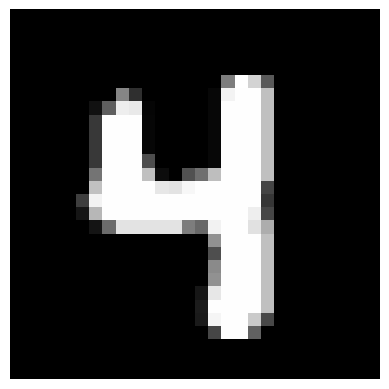

In [7]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [15]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def fit_generative_model(x, y):
    np.random.seed(42)  # Random seed
    k = 10  # number of classes
    d = x.shape[1]  # number of features

    mu = np.zeros((k, d))
    sigma = np.zeros((k, d, d))
    pi = np.zeros(k)

    # Stratified train/validation data set split
    x_train, x_validation, y_train, y_validation = train_test_split(
        x, y, test_size=1/6, stratify=y, random_state=42
    )

    candidate_c = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 20, 50, 80, 100, 500, 1000, 5000, 10000, 100000]
    best_c = None
    best_acc = -1

    # Test all the candidate c
    for c in candidate_c:
        mu_tmp = np.zeros((k, d))
        sigma_tmp = np.zeros((k, d, d))
        pi_tmp = np.zeros(k)

        # For each class, calculate prior distribution on x_train
        for j in range(k):
            xj = x_train[y_train == j]
            pi_tmp[j] = len(xj) / len(x_train)
            mu_tmp[j] = np.mean(xj, axis=0)
            centered = xj - mu_tmp[j]
            cov = centered.T @ centered / len(xj)
            cov += c * np.eye(d)
            sigma_tmp[j] = cov

        # Fit the model and get the multivariate distribution
        score = np.zeros((len(y_validation), k))

        for label in range(k):
            try:
                rv = multivariate_normal(mean=mu_tmp[label], cov=sigma_tmp[label], allow_singular=True)
            except np.linalg.LinAlgError:
                print(f"Warning: Class {label} covariance matrix is singular at c = {c}")
                continue
            # Obtain the prob distribution of each label in y_validatuon
            for i in range(len(y_validation)):
                score[i, label] = np.log(pi_tmp[label]) + rv.logpdf(x_validation[i, :])

        # Use validation data set to test the accuracy of different c
        predictions = np.argmax(score, axis=1)
        acc = accuracy_score(y_validation, predictions)
        print(f"Validation accuracy for c={c:.4g}: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_c = c
            print(f"✅ New best c found: {best_c}")

    # Final retrain using best_c
    for j in range(k):
        xj = x_train[y_train == j]
        pi[j] = len(xj) / len(x_train)
        mu[j] = np.mean(xj, axis=0)
        centered = xj - mu[j]
        cov = centered.T @ centered / len(xj)
        cov += best_c * np.eye(d)
        sigma[j] = cov

    return mu, sigma, pi, best_c

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

Validation accuracy for c=1e-06: 0.7992
✅ New best c found: 1e-06
Validation accuracy for c=1e-05: 0.7992
Validation accuracy for c=0.0001: 0.4938
Validation accuracy for c=0.001: 0.7506
Validation accuracy for c=0.01: 0.7739
Validation accuracy for c=0.1: 0.8006
✅ New best c found: 0.1
Validation accuracy for c=1: 0.8285
✅ New best c found: 1
Validation accuracy for c=5: 0.8548
✅ New best c found: 5
Validation accuracy for c=10: 0.8675
✅ New best c found: 10
Validation accuracy for c=20: 0.8808
✅ New best c found: 20
Validation accuracy for c=50: 0.8986
✅ New best c found: 50
Validation accuracy for c=80: 0.9082
✅ New best c found: 80
Validation accuracy for c=100: 0.9130
✅ New best c found: 100
Validation accuracy for c=500: 0.9370
✅ New best c found: 500
Validation accuracy for c=1000: 0.9444
✅ New best c found: 1000
Validation accuracy for c=5000: 0.9490
✅ New best c found: 5000
Validation accuracy for c=1e+04: 0.9427
Validation accuracy for c=1e+05: 0.8431


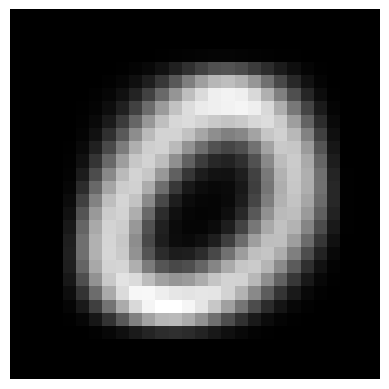

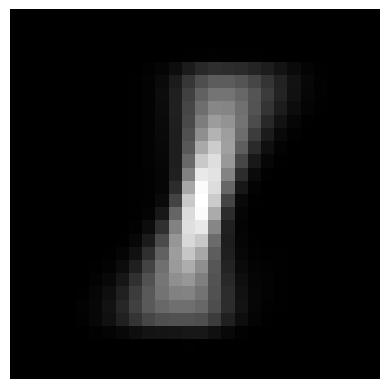

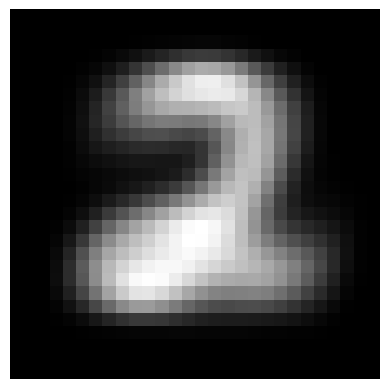

In [31]:
mu, sigma, pi, best_c = fit_generative_model(train_data, train_labels)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

In [32]:
print(best_c)

5000


## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [35]:
#
# Compute log Pr(label|image) for each [test image,label] pair.
#
k = mu.shape[0]
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
#
# Finally, tally up score
#
errors = np.sum(predictions != test_labels)
print("Your model makes " + str(errors) + " errors out of 10000")

Your model makes 434 errors out of 10000


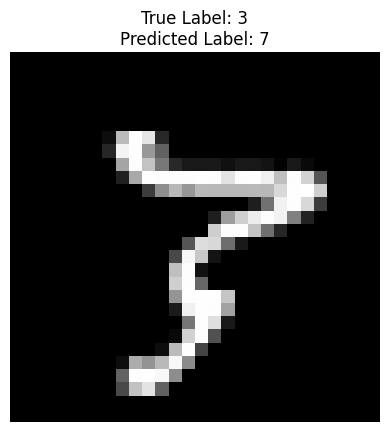

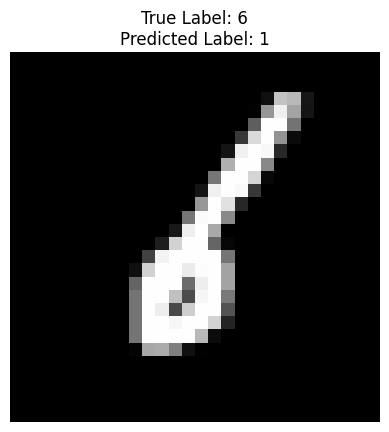

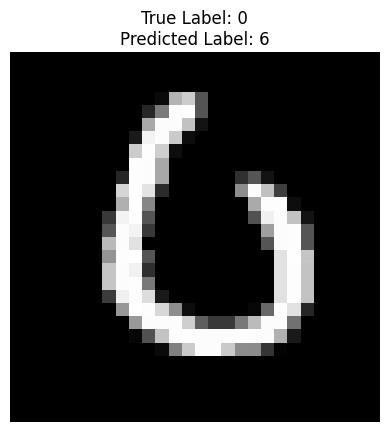

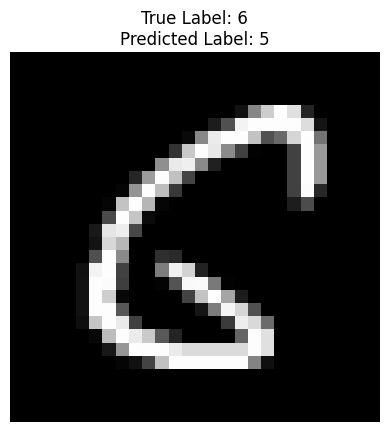

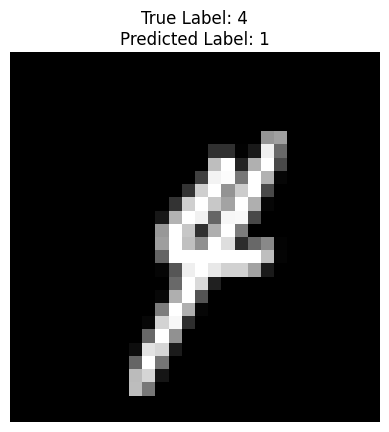

In [39]:
misclassified_idx = np.where(predictions != test_labels)[0]

# Randomly select five misclassified digits
np.random.seed(42)
selected_indices = np.random.choice(misclassified_idx, size=5, replace=False)

selected_true_labels = [test_labels[idx] for idx in selected_indices]
selected_pred_labels = [predictions[idx] for idx in selected_indices]
selected_images = [test_data[idx].reshape(28, 28) for idx in selected_indices] # Reshape for MNIST

for i in range(len(selected_indices)):
    plt.title(f'True Label: {selected_true_labels[i]}\nPredicted Label: {selected_pred_labels[i]}')
    displaychar(selected_images[i])

## 4. Things to ponder

* What happens if you do not regularize the covariance matrices?
* What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?
* What value of c did you end up using? How many errors did your model make on the training set?
* We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?

1. Without regularization, the covariance matrices might be non-singular.

2. If the c is too high (i.e. c=1000000), the accuracy of the validation set...

3. I end up using c=... In the training set, my model makes ...

4. 这样做会导致过拟合吗？？？